In [2]:
import numpy as np
np.random.seed(0)
from scipy import signal
from scipy.io import wavfile
from matplotlib import pyplot as plt
#import seaborn as sns
#sns.set(rc={'figure.figsize':(11.7,8.27)})

In [3]:
def g(x):
    return np.tanh(x)
def g_der(x):
    return 1 - g(x) * g(x)

In [4]:
def center(X):
    X = np.array(X)
    
    mean = X.mean(axis=1, keepdims=True)
    
    return X- mean

In [5]:
def whitening(X):
    cov = np.cov(X)
    d, E = np.linalg.eigh(cov)
    D = np.diag(d)
    D_inv = np.sqrt(np.linalg.inv(D))
    X_whiten = np.dot(E, np.dot(D_inv, np.dot(E.T, X)))
    return X_whiten

In [6]:
def calculate_new_w(w, X):
    w_new = (X * g(np.dot(w.T, X))).mean(axis=1) - g_der(np.dot(w.T, X)).mean() * w
    w_new /= np.sqrt((w_new ** 2).sum())
    return w_new

In [7]:
def ica(X, iterations, tolerance=1e-5):
    X = center(X)
    
    X = whitening(X)
        
    components_nr = X.shape[0]
    W = np.zeros((components_nr, components_nr), dtype=X.dtype)
    for i in range(components_nr):
            
            w = np.random.rand(components_nr)
            
            for j in range(iterations):
                
                w_new = calculate_new_w(w, X)
                
                if i >= 1:
                    w_new -= np.dot(np.dot(w_new, W[:i].T), W[:i])
                
                distance = np.abs(np.abs((w * w_new).sum()) - 1)
                
                w = w_new
                
                if distance < tolerance:
                    break
                    
            W[i, :] = w
            
    S = np.dot(W, X)
        
    return S

In [8]:
def plot_mixture_sources_predictions(X, original_sources, S):
    fig = plt.figure()
    plt.subplot(3, 1, 1)
    for x in X:
        plt.plot(x)
    plt.title("mixtures")
    plt.subplot(3, 1, 2)
    for s in original_sources:
        plt.plot(s)
    plt.title("real sources")
    plt.subplot(3,1,3)
    for s in S:
        plt.plot(s)
    plt.title("predicted sources")
    
    fig.tight_layout()
    plt.show()

In [9]:
def mix_sources(mixtures, apply_noise=False):
    for i in range(len(mixtures)):
        
        max_val = np.max(mixtures[i])
        
        if max_val > 1 or np.min(mixtures[i]) < 1:
            
            mixtures[i] = mixtures[i] / (max_val / 2) - 0.5
            
    X = np.c_[[mix for mix in mixtures]]
    
    if apply_noise:
        
        X += 0.02 * np.random.normal(size=X.shape)
        
    return X

In [10]:
n_samples = 2000
time = np.linspace(0, 8, n_samples)
s1 = np.sin(2 * time)  # sinusoidal
s2 = np.sign(np.sin(3 * time))  # square signal
s3 = signal.sawtooth(2 * np.pi * time)  # saw tooth signal

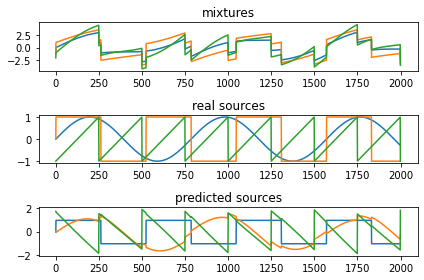

In [11]:
X = np.c_[s1, s2, s3]
A = np.array(([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]]))
X = np.dot(X, A.T)
X = X.T
S = ica(X, iterations=1000)
plot_mixture_sources_predictions(X, [s1, s2, s3], S)

In [ ]:
sampling_rate, mix1 = wavfile.read('mix1.wav')
sampling_rate, mix2 = wavfile.read('mix2.wav')
sampling_rate, source1 = wavfile.read('source1.wav')
sampling_rate, source2 = wavfile.read('source2.wav')
X = mix_sources([mix1, mix2])
S = ica(X, iterations=1000)
plot_mixture_sources_predictions(X, [source1, source2], S)
wavfile.write('out1.wav', sampling_rate, S[0])
wavfile.write('out2.wav', sampling_rate, S[1])